<div dir="rtl">

- [ ] **هدف (Goal):** ساخت مدلی برای پیش‌بینی امتیاز `overall` (از ۱ تا ۵).
- [ ] **ورودی‌ها (Inputs):** استفاده از `reviewText` (متن نظر) و `summaryText` (خلاصه نظر).
- [ ] **محدودیت اصلی (Main Constraint):** در صورت استفاده از مدل‌های پیش‌آموخته (pre-trained)، **باید** آن‌ها را Fine-tune کنید.
- [ ] **نیازمندی تیمی (Team Requirement):** تمام اعضای گروه باید الگوریتم و پیاده‌سازی آن را به طور کامل درک کرده باشند (مخصوصاً اگر از مدل‌های پیچیده‌ای مثل ترنسفورمرها استفاده می‌کنید).

</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div dir="rtl">

این دستور، جعبه ابزار کامل برای **بارگذاری مدل** (`transformers`)، **بهینه‌سازی آموزش** (`accelerate` و `datasets`) و **ارزیابی نتایج** (`scikit-learn`) را نصب می‌کند.

In [2]:
!pip install -q transformers accelerate datasets scikit-learn


<div dir="rtl">

import torch:

کتابخانه اصلی یادگیری عمیق (پای‌تورچ). تمام محاسبات مدل، بهینه‌ساز و تابع خطا بر عهده این کتابخانه است.

from torch.utils.data import Dataset, DataLoader:

این دو کلاس برای مدیریت داده‌ها حیاتی هستند. Dataset داده‌های شما را به فرمت قابل فهم برای پایتورچ در می‌آورد و DataLoader آن‌ها را به صورت دسته‌ای (batch) و بهینه به مدل می‌فرستد.

from torch.optim import AdamW:

بهینه‌ساز (Optimizer) محبوبی که به طور خاص برای مدل‌های ترنسفورمر بهینه شده است. وظیفه آن آپدیت کردن وزن‌های مدل بر اساس خطای محاسبه شده است.

import pandas as pd و import numpy as np:

pandas برای خواندن و کار با فایل‌های CSV و numpy برای کار با آرایه‌های عددی (که پایتورچ به آن نیاز دارد) استفاده می‌شود.

from sklearn. ...:

این مجموعه ابزار scikit-learn است که برای ارزیابی مدل استفاده می‌شود:

train_test_split: برای تقسیم داده‌ها به بخش آموزش و اعتبارسنجی.

classification_report و f1_score: برای محاسبه معیارهای دقت، ریکال و F1 جهت ارزیابی نهایی مدل.

compute_class_weight: (بسیار مهم) برای حل مشکل عدم توازن داده‌ها (مثلاً تعداد کم نظرات ۱ ستاره در مقابل ۵ ستاره).

from transformers. ...:

قلب پروژه شما (کتابخانه Hugging Face).

AutoTokenizer: مسئول تبدیل جملات متنی به اعداد (توکن) که مدل می‌فهمد.

AutoModelForSequenceClassification: کلاس اصلی که مدل پیش‌آموخته (مثل RoBERTa) را به همراه یک لایه دسته‌بندی (برای پیش‌بینی ۱ تا ۵ ستاره) در بالای آن بارگذاری می‌کند.

get_scheduler: برای تنظیم هوشمندانه نرخ یادگیری (Learning Rate) در طول فرآیند آموزش.

</div>

In [3]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import torch
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          DataCollatorWithPadding, get_linear_schedule_with_warmup,
                          get_scheduler)

warnings.filterwarnings("ignore")

<div dir="rtl">

MODEL_NAME = 'roberta-large':

شما مدل roberta-large را انتخاب کرده‌اید که یک مدل بسیار قدرتمند و بزرگ برای درک زبان است.

MAX_LENGTH = 256:

حداکثر طولی (بر حسب توکن) که هر نظر می‌تواند داشته باشد. متن‌های بلندتر از این مقدار، کوتاه (truncate) خواهند شد.

NUM_LABELS = 5:

تعداد کلاس‌های خروجی. در اینجا ۵ کلاس (برای امتیاز ۱ تا ۵) است.

BATCH_SIZE = 8:

تعداد نمونه‌هایی که در هر مرحله از آموزش به مدل داده می‌شود. (این بچ سایز نسبت به کد قبلی که 4 بود، بزرگتر شده است).

NUM_EPOCHS = 4:

تعداد کل دفعاتی که مدل تمام داده‌های آموزشی را مرور خواهد کرد.

LEARNING_RATE = 1e-5:

نرخ یادگیری. یک مقدار استاندارد و خوب برای فاین-تیونینگ مدل‌های ترنسفورمر.

SEED = 42:

یک عدد ثابت برای اطمینان از اینکه نتایج شما (مانند تقسیم داده‌ها) قابل تکرار هستند.

CLIP_GRAD_NORM = 1.0:

مقداری برای "بریده‌سازی گرادیان" (Gradient Clipping) تا از مشکل انفجار گرادیان (exploding gradients) و ناپایدار شدن آموزش جلوگیری کند.

File Paths:

آدرس‌های دقیق فایل‌های داده ورودی (TRAIN_DATA_PATH, TEST_DATA_PATH) و فایل‌های خروجی (BEST_MODEL_PATH, SUBMISSION_FILE_PATH).

</div>

In [4]:
# Model & Tokenizer
MODEL_NAME = 'roberta-large'
MAX_LENGTH = 256
NUM_LABELS = 5

# Training Hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 4
LEARNING_RATE = 1e-5
SEED = 42
CLIP_GRAD_NORM = 1.0

# File Paths
TRAIN_DATA_PATH = '/content/drive/MyDrive/Project2/train_data_cleaned.csv'
TEST_DATA_PATH = '/content/drive/MyDrive/Project2/test_data_cleaned.csv'
BEST_MODEL_PATH = 'best_roberta_large_model.bin'
SUBMISSION_FILE_PATH = 'submission_final.csv'

<div dir="rtl">

توضیح کلاس SentimentDataset
این کلاس از کلاس Dataset خود پایتورچ ارث‌بری می‌کند و باید سه متد اصلی را پیاده‌سازی کند:

۱. def __init__(self, ...) (متد سازنده)
وظیفه: آماده‌سازی و ذخیره مواد اولیه.

چه می‌کند: زمانی که شما این کلاس را ایجاد می‌کنید، این متد فراخوانی می‌شود و لیست تمام متن‌ها (texts)، لیست تمام لیبل‌ها (labels)، توکنایزر (tokenizer) و حداکثر طول (max_len) را به عنوان ورودی می‌گیرد و آن‌ها را در متغیرهای داخلی کلاس (مثل self.texts) ذخیره می‌کند تا بعداً بتواند از آن‌ها استفاده کند.

۲. def __len__(self) (متد طول)
وظیفه: گزارش تعداد کل نمونه‌ها.

چه می‌کند: DataLoader پایتورچ این متد را صدا می‌زند تا بداند که کل دیتاست شما چند نمونه دارد. در اینجا، به سادگی تعداد متن‌ها (یا لیبل‌ها) را برمی‌گرداند.

۳. def __getitem__(self, idx) (متد دریافت نمونه)
وظیفه: آماده‌سازی و تحویل یک نمونه داده.

چه می‌کند: این مهم‌ترین متد کلاس است. DataLoader این متد را برای هر نمونه (با دادن یک idx یا شماره ردیف) فراخوانی می‌کند.

text = str(self.texts[idx]): متن مربوط به آن ردیف را برمی‌دارد.

label = self.labels[idx]: لیبل (امتیاز) مربوط به همان ردیف را برمی‌دارد.

encoding = self.tokenizer.encode_plus(...):

اصل جادو اینجاست. توکنایزر متن خام را می‌گیرد و آن را به اعداد تبدیل می‌کند.

padding='max_length': به متن‌هایی که کوتاه‌تر از max_len (یعنی ۲۵۶) هستند، توکن‌های [PAD] اضافه می‌کند تا هم‌اندازه شوند.

truncation=True: متن‌های بلندتر از max_len را کوتاه (truncate) می‌کند.

return_tensors='pt': خروجی را به صورت تنسورهای پایتورچ (pt) برمی‌گرداند.

return { ... }: در نهایت، یک دیکشنری حاوی سه کلید اصلی که مدل به آن‌ها نیاز دارد را برمی‌گرداند:

'input_ids': آرایه‌ای از اعداد (توکن‌ها) که نماینده متن هستند.

'attention_mask': آرایه‌ای از 0 و 1 که به مدل می‌گوید به کدام توکن‌ها باید توجه کند (1) و کدام‌ها پدینگ هستند (0).

'labels': لیبل (امتیاز) آن نمونه.

</div>

In [5]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


<div dir="rtl">

توضیح تابع create_data_loader
این تابع یک "کارخانه" کوچک است که فرآیند آماده‌سازی داده‌ها برای آموزش را بسیار ساده می‌کند.

وظیفه اصلی آن، تبدیل یک دیتافریم pandas (که خواندن آن برای انسان راحت است) به یک آبجکت DataLoader (که برای پایتورچ و GPU بهینه است) می‌باشد.

این کار در دو مرحله انجام می‌شود:

۱. ساخت SentimentDataset
Python

ds = SentimentDataset(...)
ابتدا، کلاسی را که قبلاً تعریف کردیم (SentimentDataset) فراخوانی می‌کند.

تمام متن‌ها و لیبل‌ها را از دیتافریم (df) به این کلاس می‌دهد.

حالا ds یک آبجکت است که می‌داند چگونه تک تک ردیف‌های داده را به فرمت عددیِ قابل فهم برای مدل (یعنی input_ids, attention_mask, labels) تبدیل کند.

۲. ساخت DataLoader
Python

return DataLoader(ds, ...)
سپس، آبجکت ds (که داده‌های تکی را آماده می‌کند) به DataLoader داده می‌شود.

DataLoader وظیفه دارد داده‌ها را از ds بگیرد و آن‌ها را به صورت دسته‌ای (Batch) سازماندهی کند.

batch_size=batch_size: به آن می‌گوید که در هر دسته چند نمونه قرار دهد (مثلاً ۸ تا).

shuffle=shuffle: مشخص می‌کند که آیا ترتیب داده‌ها باید بُر بخورد یا نه (که برای آموزش True و برای ارزیابی False است).

num_workers=2: یک بهینه‌سازی مهم برای سرعت است. این دستور به پایتورچ می‌گوید که از ۲ پردازش جداگانه برای آماده‌سازی دسته‌ها در پس‌زمینه استفاده کند. این کار مانع از ایجاد گلوگاه (bottleneck) می‌شود و تضمین می‌کند که GPU همیشه داده برای پردازش داشته باشد.

</div>

In [6]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle=False):
    ds = SentimentDataset(
        texts=df.input_text.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=2)


<div dir="rtl">

بخش اول: آماده‌سازی محیط و بارگذاری داده‌ها
این بخش با عبارت if __name__ == "__main__" آغاز می‌شود که نقطه ورود اصلی اسکریپت پایتون است. در ابتدا، با استفاده از np.random.seed و torch.manual_seed، یک "بذر تصادفی" (SEED) ثابت تنظیم می‌شود تا اگر کد را صد بار هم اجرا کنید، نتایج (مانند تقسیم داده‌ها) همیشه یکسان و قابل تکرار باشند. سپس، اسکریپت چک می‌کند که آیا GPU (cuda) در دسترس است یا خیر و دستگاه مناسب را انتخاب می‌کند. پس از آن، توکنایزر متناظر با مدل roberta-large بارگذاری می‌شود. در ادامه، فایل CSV داده‌های آموزشی خوانده شده، ستون‌های مورد نیاز (text, summary, y) انتخاب می‌شوند، سطرهای خالی حذف می‌گردند و ستون summary که ممکن است مقادیر خالی داشته باشد، با یک رشته خالی پر می‌شود. مهم‌ترین بخش پردازش در اینجا، ساخت ستون input_text از طریق چسباندن text و summary به یکدیگر است و در نهایت، لیبل‌ها از 1-5 به 0-4 شیفت داده می‌شوند تا برای مدل قابل فهم باشند.
</br>
</br>
بخش دوم: نمونه‌برداری و تقسیم داده‌ها
در این مرحله، یک نمونه‌برداری آزمایشی انجام می‌شود. کد چک می‌کند که آیا تعداد کل داده‌ها بیشتر از ۳۰۰۰ است یا خیر. اگر بود، برای تست سریع و اجرای آزمایشی کد، فقط ۳۰۰۰ نمونه به صورت تصادفی از کل دیتافریم انتخاب می‌شود. این کار برای دیباگ کردن و اجرای سریع در محیط‌هایی مثل Colab بسیار مفید است. سپس، این ۳۰۰۰ نمونه (یا کل داده‌ها، اگر کمتر از ۳۰۰۰ بودند) با استفاده از train_test_split به دو بخش آموزشی (۸۵ درصد) و اعتبارسنجی (۱۵ درصد) تقسیم می‌شوند. نکته بسیار مهم در اینجا، استفاده از stratify=df['label'] است که تضمین می‌کند توزیع امتیازها (مثلاً درصد امتیاز ۱ ستاره یا ۵ ستاره) در هر دو مجموعه آموزشی و اعتبارسنجی یکسان باقی بماند.
</br>
</br>
بخش سوم: ساخت لودرها، مدل و تابع خطا
پس از تقسیم داده‌ها، تابع کمکی create_data_loader فراخوانی می‌شود تا دیتا لودرهای آموزشی (train_loader) و اعتبارسنجی (val_loader) را بسازد. train_loader داده‌ها را بُر می‌زند (shuffle=True) که برای فرآیند یادگیری حیاتی است، اما val_loader این کار را نمی‌کند. سپس، مدل اصلی (roberta-large برای دسته‌بندی با ۵ خروجی) از Hugging Face بارگذاری شده و بلافاصله به GPU منتقل می‌شود (model.to(device)). در ادامه، بهینه‌ساز AdamW و یک زمان‌بند نرخ یادگیری (lr_scheduler) از نوع "cosine_with_restarts" تعریف می‌شوند که به مدل کمک می‌کند هوشمندانه‌تر یاد بگیرد. در نهایت، بخش حیاتی مقابله با عدم توازن داده‌ها فرا می‌رسد: با استفاده از compute_class_weight، وزن‌هایی برای کلاس‌های مختلف محاسبه می‌شود (کلاس‌های کم‌تعدادتر وزن بیشتری می‌گیرند) و این وزن‌ها به تابع خطای CrossEntropyLoss داده می‌شوند. این کار باعث می‌شود مدل به اشتباهات خود در مورد کلاس‌های کم‌تعداد (مثل ۱ ستاره) اهمیت بیشتری بدهد.
</br>
</br>
بخش چهارم: حلقه آموزش و اعتبارسنجی (قلب فرآیند)
این بخش، حلقه اصلی آموزش است که به تعداد NUM_EPOCHS (مثلاً ۴ بار) تکرار می‌شود. در ابتدای هر Epoch، مدل با model.train() در حالت آموزش قرار می‌گیرد. سپس، در یک حلقه داخلی، داده‌ها به صورت بچ به بچ از train_loader گرفته شده و به GPU منتقل می‌شوند. برای هر بچ، گرادیان‌ها ابتدا صفر شده (optimizer.zero_grad())، سپس داده‌ها به مدل داده می‌شوند و loss (میزان خطا) محاسبه می‌گردد (loss.backward()). پس از آن، گرادیان‌ها کلیپ (clip) شده تا از ناپایداری جلوگیری شود و در نهایت، وزن‌های مدل با optimizer.step() آپدیت شده و نرخ یادگیری با lr_scheduler.step() تنظیم می‌گردد. پس از اتمام تمام بچ‌های آموزشی، مدل با model.eval() در حالت ارزیابی قرار می‌گیرد و با torch.no_grad() (برای صرفه‌جویی در حافظه)، عملکرد آن روی تمام داده‌های val_loader سنجیده می‌شود. امتیاز F1 (current_f1) محاسبه شده و اگر این امتیاز از بهترین امتیاز قبلی (best_f1) بیشتر بود، مدل فعلی به عنوان "بهترین مدل" در فایلی با نام BEST_MODEL_PATH ذخیره می‌شود.
</br>
</br>
بخش پنجم: ارزیابی نهایی و ساخت فایل خروجی
پس از اتمام تمام Epochها، بهترین مدلی که در طول فرآیند ذخیره شده بود، دوباره با model.load_state_dict() بارگذاری می‌شود. مدل در حالت ارزیابی قرار گرفته و یک بار دیگر روی داده‌های اعتبارسنجی اجرا می‌شود تا گزارش نهایی و کامل (classification_report) شامل Precision, Recall و F1-Score برای هر کلاس چاپ شود. در نهایت، داده‌های تست (test_data_cleaned.csv) خوانده شده، دقیقاً مانند داده‌های آموزشی پردازش می‌شوند (ترکیب text و summary). با استفاده از یک ترفند هوشمندانه (ایجاد ستون ساختگی label = 0)، از همان create_data_loader برای داده‌های تست استفاده می‌شود. مدل بهترین، روی داده‌های تست اجرا شده، پیش‌بینی‌ها (test_preds) جمع‌آوری می‌شوند، این پیش‌بینی‌ها از 0-4 به 1-5 (با + 1) برگردانده شده و در نهایت، فایل submission_final.csv برای ارسال، ساخته می‌شود.

</div>

<div dir="rtl">

 roberta-large یکی از قوی‌ترین و محبوب‌ترین مدل‌های پردازش زبان طبیعی (NLP) است. انتخاب این مدل برای پروژه شما یک انتخاب هدفمند برای رسیدن به بالاترین دقت ممکن بود.

#roberta-large چیست؟
یک مدل ترنسفورمر پیشرفته: roberta-large (که مخفف Robustly Optimized BERT Approach است) یک مدل زبانی است که توسط فیسبوک (Meta AI) به عنوان نسخه‌ی بهینه‌سازی شده‌ی مدل معروف BERT گوگل، توسعه داده شد.

نسخه "Large" (بزرگ): این مدل حدود ۳۵۵ میلیون پارامتر دارد. این پارامترها مثل سلول‌های مغزی مدل هستند. هرچه تعداد آن‌ها بیشتر باشد، مدل می‌تواند الگوهای پیچیده‌تری را در زبان یاد بگیرد. (در مقام مقایسه، roberta-base حدود ۱۲۵ میلیون و DistilBERT حدود ۶۶ میلیون پارامتر دارد).

آموزش بسیار هوشمندانه: تفاوت اصلی RoBERTa با BERT در نحوه آموزش آن است. تیم فیسبوک دریافتند که اگر BERT را روی داده‌های بسیار بیشتر (۱۶۰ گیگابایت متن در مقابل ۱۶ گیگابایت BERT) و برای مدت زمان طولانی‌تر آموزش دهند و برخی از اهداف آموزشی آن را بهینه‌سازی کنند، نتیجه به طور شگفت‌انگیزی بهتر می‌شود.

به طور خلاصه: roberta-large یک نسخه تکامل‌یافته، قوی‌تر و "باسوادتر" از مدل BERT است.

#چرا از این مدل برای پروژه استفاده کردیم؟
دلیل اصلی این بود که شما به دنبال "بهترین نتیجه" بودید. وقتی هدف، رسیدن به بالاترین دقت (Accuracy) و F1-Score باشد، roberta-large یکی از بهترین گزینه‌های موجود است.

درک عمیق از زبان (Understanding Nuance): تحلیل احساسات و امتیازدهی (۱ تا ۵ ستاره) کار ساده‌ای نیست. مدل باید بتواند تفاوت بین "بد نبود" و "خوب بود" را بفهمد. همچنین باید بتواند کنایه (sarcasm) یا جملات پیچیده را درک کند.

مثال: "من انتظار یک شاهکار داشتم، اما فیلم فقط خوب بود."

یک مدل کوچک ممکن است کلمه "خوب" را ببیند و امتیاز ۴ یا ۵ بدهد. اما roberta-large به دلیل آموزش گسترده‌اش، می‌تواند کل جمله را درک کرده و بفهمد که این نظر، بیشتر به یک امتیاز ۳ (یعنی متوسط یا کمی ناامیدکننده) نزدیک است.

قدرت پیش‌آموزش (Pre-training Power): این مدل قبلاً روی ۱۶۰ گیگابایت متن (شامل کتاب‌ها، مقالات و وب‌سایت‌ها) آموزش دیده است. این یعنی مدل از قبل، درک بسیار خوبی از گرامر، مفاهیم و ارتباط کلمات با هم دارد.

کاری که ما در پروژه شما انجام می‌دهیم (یعنی Fine-Tuning)، در واقع مثل این است که یک متخصص زبان‌شناسی بسیار باتجربه را استخدام کنیم و به او فقط یک وظیفه جدید یاد بدهیم: "حالا از تمام دانش خودت برای امتیازدهی به این نقدها استفاده کن."

عملکرد اثبات‌شده (State-of-the-Art): roberta-large در زمان انتشار و تا مدت‌ها بعد، رکوردهای بسیاری را در بنچ‌مارک‌های مختلف NLP (از جمله تحلیل احساسات) شکست. این یک مدل امتحان‌پس‌داده و قابل اعتماد برای رسیدن به بالاترین دقت است.

نقطه ضعف (The Trade-off):
البته این قدرت هزینه‌ای هم دارد:

اندازه و سرعت: roberta-large یک مدل بسیار سنگین است. هم حافظه GPU زیادی مصرف می‌کند و هم فرآیند آموزش و پیش‌بینی آن کندتر از مدل‌های سبک‌تری مثل DistilBERT است. به همین دلیل بود که در کدهای پیشرفته‌تر، ما مجبور بودیم از BATCH_SIZE پایین (مثل ۴ یا ۸) و تکنیک‌هایی مانند Mixed Precision و Gradient Accumulation استفاده کنیم تا مدل در حافظه GPU جا شود و آموزش آن ممکن گردد.

نتیجه‌گیری: ما roberta-large را انتخاب کردیم چون شما به دنبال حداکثر دقت بودید و این مدل به دلیل درک عمیق و آموزش گسترده‌اش، بهترین شانس را برای درک نظرات پیچیده کاربران و دادن امتیاز دقیق فراهم می‌کند.

</div>

In [22]:
if __name__ == "__main__":
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    print("Loading and processing data...")
    df = pd.read_csv(TRAIN_DATA_PATH, dtype={'y': 'Int64'})
    df = df[['text', 'summary', 'y']].dropna(subset=['text', 'y'])
    df['summary'] = df['summary'].fillna('')
    df['input_text'] = df['text'].astype(str) + ' </s> ' + df['summary'].astype(str)
    df['label'] = df['y'] - 1

    if len(df) > 20000:
        df = df.sample(n=20000, random_state=SEED)
        print(f"Running on a random sample of 20000 items.")
    else:
        print(f"Dataset has less than 20000 items, running on all {len(df)} items.")

    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=SEED, stratify=df['label']
    )

    train_loader = create_data_loader(train_df, tokenizer, MAX_LENGTH, BATCH_SIZE, shuffle=True)
    val_loader = create_data_loader(val_df, tokenizer, MAX_LENGTH, BATCH_SIZE)
    print("Data loading complete.")

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    num_training_steps = NUM_EPOCHS * len(train_loader)
    lr_scheduler = get_scheduler(
        "cosine_with_restarts", optimizer=optimizer, num_warmup_steps=50, num_training_steps=num_training_steps
    )

    class_weights = compute_class_weight(
        'balanced', classes=np.unique(train_df['label']), y=train_df['label'].to_numpy()
    )
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

    print("Starting model training on 3000 samples...")
    best_f1 = 0
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
            optimizer.step()
            lr_scheduler.step()
            total_loss += loss.item()

            if step % 100 == 0 and step != 0:
                print(f"  Step {step}, Loss: {total_loss / (step + 1):.4f}")

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f}")


        model.eval()
        all_preds, all_labels = [], []
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()
                predictions = torch.argmax(outputs.logits, dim=-1)
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}")
        current_f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Validation F1 Score: {current_f1:.4f}")

        if current_f1 > best_f1:
            best_f1 = current_f1
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"New best model saved to {BEST_MODEL_PATH}")

    print(f"\nTraining Complete. Best F1-Score: {best_f1:.4f}")

    print("\nLoading best model for final evaluation and submission...")
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    print("\nFinal Classification Report on Validation Set:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(1, 6)]))


Using device: cuda
Loading and processing data...
Running on a random sample of 20000 items.
Data loading complete.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting model training on 3000 samples...

Epoch 1/4
  Step 100, Loss: 1.2788
  Step 200, Loss: 1.1006
  Step 300, Loss: 0.9783
  Step 400, Loss: 0.9176
  Step 500, Loss: 0.8827
  Step 600, Loss: 0.8475
  Step 700, Loss: 0.8286
  Step 800, Loss: 0.8152
  Step 900, Loss: 0.7997
  Step 1000, Loss: 0.7894
  Step 1100, Loss: 0.7835
  Step 1200, Loss: 0.7724
  Step 1300, Loss: 0.7667
  Step 1400, Loss: 0.7611
  Step 1500, Loss: 0.7563
  Step 1600, Loss: 0.7498
  Step 1700, Loss: 0.7427
  Step 1800, Loss: 0.7392
  Step 1900, Loss: 0.7363
  Step 2000, Loss: 0.7305
  Step 2100, Loss: 0.7254
Epoch 1 Training Loss: 0.7233
Epoch 1 Validation Loss: 0.7296
Validation F1 Score: 0.7099
New best model saved to best_roberta_large_model.bin

Epoch 2/4
  Step 100, Loss: 0.5561
  Step 200, Loss: 0.5577
  Step 300, Loss: 0.5361
  Step 400, Loss: 0.5350
  Step 500, Loss: 0.5361
  Step 600, Loss: 0.5286
  Step 700, Loss: 0.5280
  Step 800, Loss: 0.5232
  Step 900, Loss: 0.5238
  Step 1000, Loss: 0.5231
  St

In [2]:
print("\nGenerating final submission file...")
test_df = pd.read_csv(TEST_DATA_PATH)

test_df['input_text'] = test_df['text'].astype(str) + ' </s> ' + ''

test_texts = test_df.input_text.tolist()
test_preds = []

test_df['label'] = 0
test_loader = create_data_loader(test_df, tokenizer, MAX_LENGTH, BATCH_SIZE)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        test_preds.extend(predictions.cpu().numpy())

submission_preds = np.array(test_preds) + 1
submission_df = pd.DataFrame({'predicted': submission_preds})
submission_df.to_csv(SUBMISSION_FILE_PATH, index=False)

print(f"Final submission file created at: {SUBMISSION_FILE_PATH}")


Generating final submission file...


NameError: name 'pd' is not defined

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def plot_classification_report(report):
    report_df = pd.DataFrame(report).iloc[:-1, :].T

    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df, annot=True, cmap='Blues', fmt='.3f')
    plt.title('Classification Metrics per Class', fontsize=16)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Classes', fontsize=12)
    plt.show()

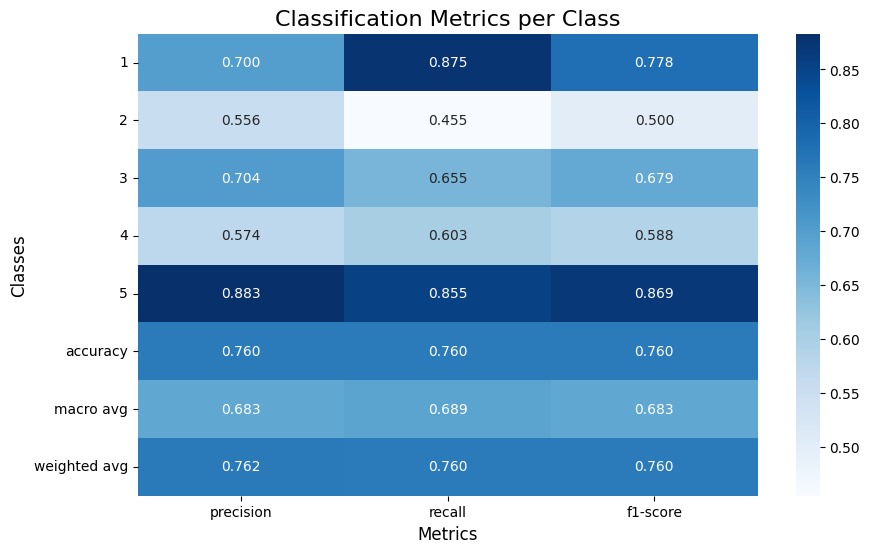

In [21]:
target_names = [str(i) for i in range(1, 6)]

report_dict = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True)
plot_classification_report(report_dict)